# Model comparison

This notebook runs a ResNet18 model to measure the difference in performance in comparison to the standard's ResNet34 model. The training metrics here are compared against those from the Standard_for_ablation_comparison.ipynb notebook, and interpreted/summarized at the end of the notebook.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rnapark","key":"f766d3a80003b91cb04f4e4633ffd077"}'}

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list

ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000           5092        104  1.0              
sadiajavedd/students-academic-performance-dataset               Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000          10823        272  1.0              
kundanbedmutha/customer-sentiment-dataset                       Customer Sentiment Dataset                              296232  2025-11-19 08:18:50.493000            991         27  1.0              


In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

plant_pathology_2020_fgvc7_path = kagglehub.competition_download('plant-pathology-2020-fgvc7')
rnapark_resnet18_f37072fd_pth_path = kagglehub.dataset_download('rnapark/resnet18-f37072fd-pth')
rnapark_resnet34_b627a593_pth_path = kagglehub.dataset_download('rnapark/resnet34-b627a593-pth')

print('Data source import complete.')


100%|██████████| 779M/779M [00:14<00:00, 57.5MB/s]

Extracting files...


100%|██████████| 41.4M/41.4M [00:00<00:00, 129MB/s] 

Extracting files...


100%|██████████| 77.2M/77.2M [00:00<00:00, 102MB/s] 

Extracting files...


Data source import complete.


# Load data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image
import os

class AppleDataset(Dataset):
  def __init__(self, csv_path, images, transform=None, is_test=False):
    self.data = pd.read_csv(csv_path)
    self.images = images
    self.transform = transform
    self.is_test = is_test

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    image_path = os.path.join(self.images, row['image_id']+".jpg")
    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    if self.is_test:
      return image
    else:
      label = row[['healthy', 'multiple_diseases', 'rust', 'scab']].values.astype("float32")
      return image, label


# Input data files are available in the read-only "../input/" directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# file paths
base_dir = plant_pathology_2020_fgvc7_path
train_csv = base_dir + "/train.csv"
test_csv  = base_dir + "/test.csv"
images = base_dir + "/images"

train_data = AppleDataset(train_csv, images, transform=None)
test_data  = AppleDataset(test_csv, images, transform=None, is_test=True)

# Commented out the below because transforms are not defined until later
# train_set, val_set = random_split(train_data, [0.8, 0.2])

# # Prepare DataLoaders
# train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# print("Data loaded successfully!")
# print("Train batches:", len(train_loader))
# print("Val batches:", len(val_loader))
# print("Test batches:", len(test_loader))

# images, labels = next(iter(train_loader))
# print(images.shape)  # (64, 3, H, W)
# print(labels.shape)  # (64, 4)


## Helper to visualize training curves

In [ ]:
from matplotlib import pyplot as plt

# Helper function to visualize performance during training
def plot_training_curves(train_losses, val_accuracies):
    """Plot training loss and validation accuracy curves.

    Parameters
    ----------
    train_losses : list of float
        Training loss values for each epoch. Should have one value per epoch.
    val_accuracies : list of float
        Validation accuracy values for each epoch. Should have same length as
        train_losses. Accuracy values should be between 0 and 1 (or 0 and 100
        if using percentages).

    Returns
    -------
    None
        Displays matplotlib figure with two subplots showing training curves.

    Examples
    --------
    >>> train_losses = [0.8, 0.6, 0.4, 0.3, 0.2]
    >>> val_accuracies = [0.75, 0.80, 0.85, 0.87, 0.88]
    >>> plot_training_curves(train_losses, val_accuracies)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Define training loop, evaluation loop

In [ ]:
# Define train/test loop

def mixup_data(x, y, alpha=0.2):
    # Returns mixed inputs, pairs of targets, and lambda
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_loop(
        dataloader,
        model,
        loss_fn,
        optimizer,
        device,
        smoothing=0.02,
        grad_clip=1.0,
        use_mixup=True,
        mixup_alpha=0.2
    ):

    model.train()
    total_loss = 0.0

    for X, y in dataloader:
        X = X.to(device)
        y = y.float().to(device)
        y_smooth = y * (1 - smoothing) + (1 - y) * smoothing

        # MixUp augmentation
        if use_mixup:
            X, y_a, y_b, lam = mixup_data(X, y_smooth, alpha=mixup_alpha)

            # Apply label smoothing AFTER mixup
            y_a = y_a * (1 - smoothing) + (1 - y_a) * smoothing
            y_b = y_b * (1 - smoothing) + (1 - y_b) * smoothing

            pred = model(X)
            loss = lam * loss_fn(pred, y_a) + (1 - lam) * loss_fn(pred, y_b)
        else:
            # Only smoothing if NOT using mixup
            y_smooth = y * (1 - smoothing) + (1 - y) * smoothing
            pred = model(X)
            loss = loss_fn(pred, y_smooth)

        optimizer.zero_grad()
        loss.backward()

        # gradient clipping
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)
def evaluate_model(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct_predictions_sum = 0, 0
    num_labels = 4 # Number of output labels in our dataset

    model.eval()
    with torch.no_grad():
      for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X) # These are logits
        test_loss += loss_fn(pred, y).item()

        # Apply sigmoid to logits to get probabilities
        probabilities = torch.sigmoid(pred)
        # Threshold probabilities to get binary predictions (0 or 1)
        predicted_labels = (probabilities > 0.5).float()
        # Count total correct individual label predictions (TP + TN)
        correct_predictions_sum += (predicted_labels == y).float().sum().item()

    test_loss = test_loss / num_batches
    # Calculate overall accuracy as the ratio of correctly predicted individual labels
    # to the total possible individual labels (num_samples * num_labels)
    total_possible_labels = size * num_labels
    accuracy = correct_predictions_sum / total_possible_labels
    return test_loss, accuracy

def predict_loop(loader, model, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Raw probabilities for each class

            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    return torch.cat(all_labels, dim=0), torch.cat(all_probs, dim=0)

def predict_test_loop(loader, model, device):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                images = batch[0]
            else:
                images = batch

            images = images.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Raw probabilities

            all_probs.append(probs.cpu())

    return torch.cat(all_probs, dim=0)


# Improving model with fine tuning

In [ ]:
def apply_thresholding(probs, thresholds):
    #Apply thresholds to the predicted probabilities.

    # Initialize an array to store the predictions for each sample
    preds = torch.zeros_like(probs, dtype=torch.long)

    for i in range(probs.shape[0]):  # Iterate over each sample in the batch
        for c in range(probs.shape[1]):  # Iterate over each class
            if probs[i, c] > thresholds[c]:  # Check if the probability exceeds the threshold
                preds[i, c] = 1  # Set the class prediction to 1 (indicating the class is selected)

    # For each sample, choose the class with the maximum probability if no class exceeds threshold
    preds = torch.argmax(probs, dim=1)  # Use the highest probability class if no threshold is surpassed

    return preds

## Defining visualizations for evaluation

In [ ]:
# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score, precision_recall_fscore_support

def plot_confusion_matrix(y_true, y_pred, class_names):
    # Generate a confusion matrix for each class in a one-vs-rest manner
    for i, class_name in enumerate(class_names):
        # For each class, consider it as positive and all others as negative
        true_labels = y_true[:, i]
        pred_labels = y_pred[:, i]
        cm = confusion_matrix(true_labels, pred_labels)

        # Extract metrics
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0) # Handle cases where a class might not be present
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"\nMetrics for class: {class_name}")
        print(f"  True Positives (TP): {tp}")
        print(f"  False Positives (FP): {fp}")
        print(f"  False Negatives (FN): {fn}")
        print(f"  True Negatives (TN): {tn}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")

        # Calculate and print F1-score
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        print(f"  F1-score: {f1_score:.4f}")

        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=[f'Not {class_name}', class_name],
                    yticklabels=[f'Not {class_name}', class_name])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {class_name}')
        plt.show()

def plot_precision_recall_curve(y_true, y_pred, class_names):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        plt.plot(recall, precision, label=f'{class_names[i]}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

def plot_roc_curve(y_true, y_pred, class_names):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()


Training fold 1...
Epoch 1/15 - Fold 1
Training Loss: 1.1361, Validation Loss: 1.0159, Validation Accuracy: 0.4753
Epoch 2/15 - Fold 1
Training Loss: 1.0846, Validation Loss: 0.9547, Validation Accuracy: 0.5829
Epoch 3/15 - Fold 1
Training Loss: 1.0142, Validation Loss: 0.8687, Validation Accuracy: 0.6384
Epoch 4/15 - Fold 1
Training Loss: 0.9365, Validation Loss: 0.7558, Validation Accuracy: 0.6726
Epoch 5/15 - Fold 1
Training Loss: 0.8849, Validation Loss: 0.6673, Validation Accuracy: 0.7103
Epoch 6/15 - Fold 1
Training Loss: 0.7891, Validation Loss: 0.5797, Validation Accuracy: 0.7384
Epoch 7/15 - Fold 1
Training Loss: 0.7620, Validation Loss: 0.5184, Validation Accuracy: 0.7740
Epoch 8/15 - Fold 1
Training Loss: 0.7435, Validation Loss: 0.4776, Validation Accuracy: 0.8390
Epoch 9/15 - Fold 1
Training Loss: 0.7720, Validation Loss: 0.4614, Validation Accuracy: 0.8507
Epoch 10/15 - Fold 1
Training Loss: 0.7039, Validation Loss: 0.4314, Validation Accuracy: 0.8637
Epoch 11/15 - Fold 

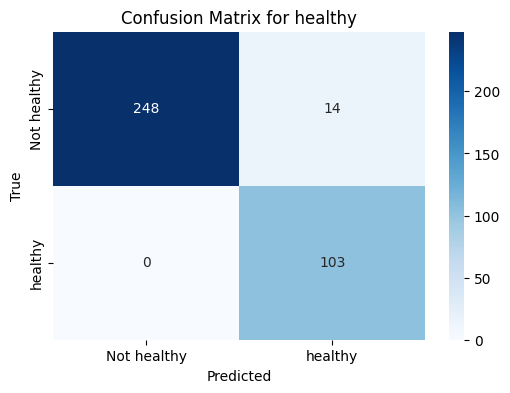


Metrics for class: multiple_diseases
  True Positives (TP): 15
  False Positives (FP): 49
  False Negatives (FN): 3
  True Negatives (TN): 298
  Precision: 0.2344
  Recall: 0.8333
  F1-score: 0.3659


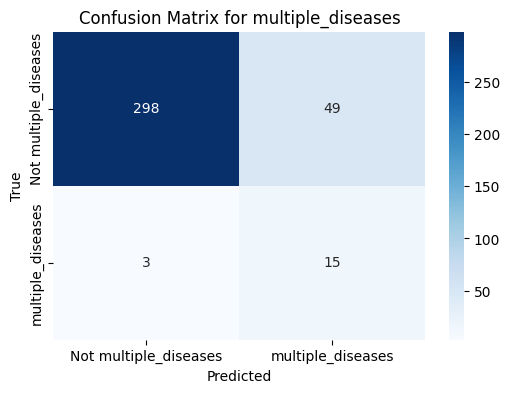


Metrics for class: rust
  True Positives (TP): 125
  False Positives (FP): 14
  False Negatives (FN): 0
  True Negatives (TN): 226
  Precision: 0.8993
  Recall: 1.0000
  F1-score: 0.9470


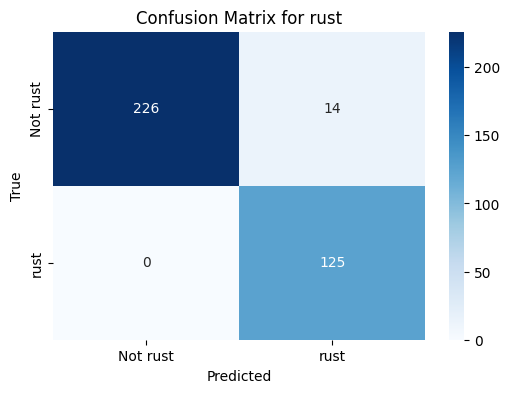


Metrics for class: scab
  True Positives (TP): 112
  False Positives (FP): 4
  False Negatives (FN): 7
  True Negatives (TN): 242
  Precision: 0.9655
  Recall: 0.9412
  F1-score: 0.9532


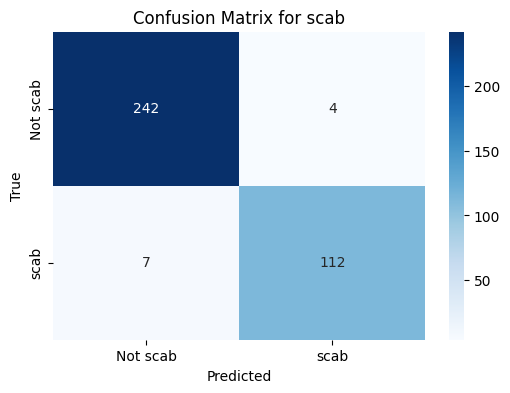

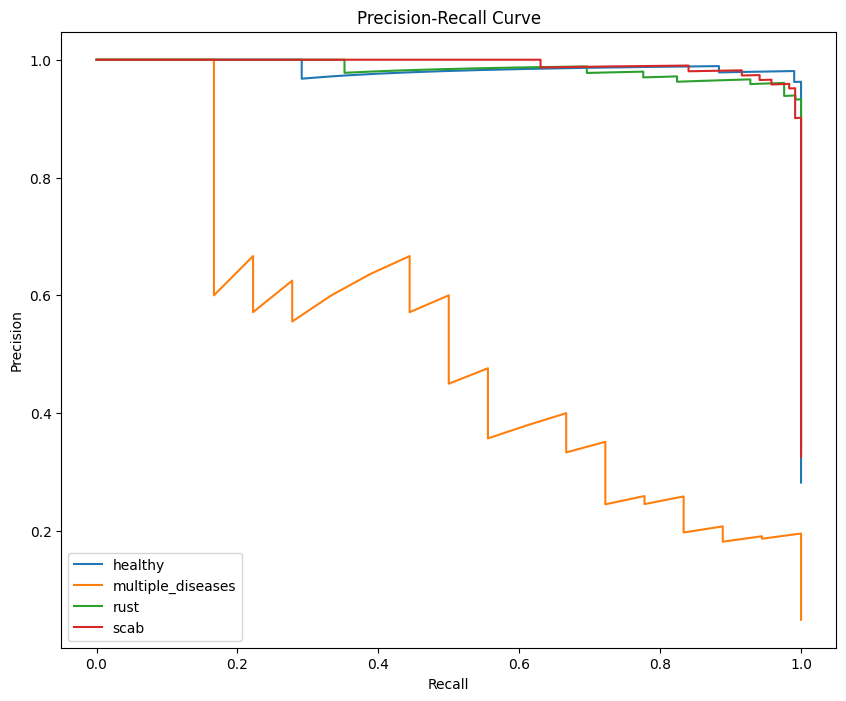

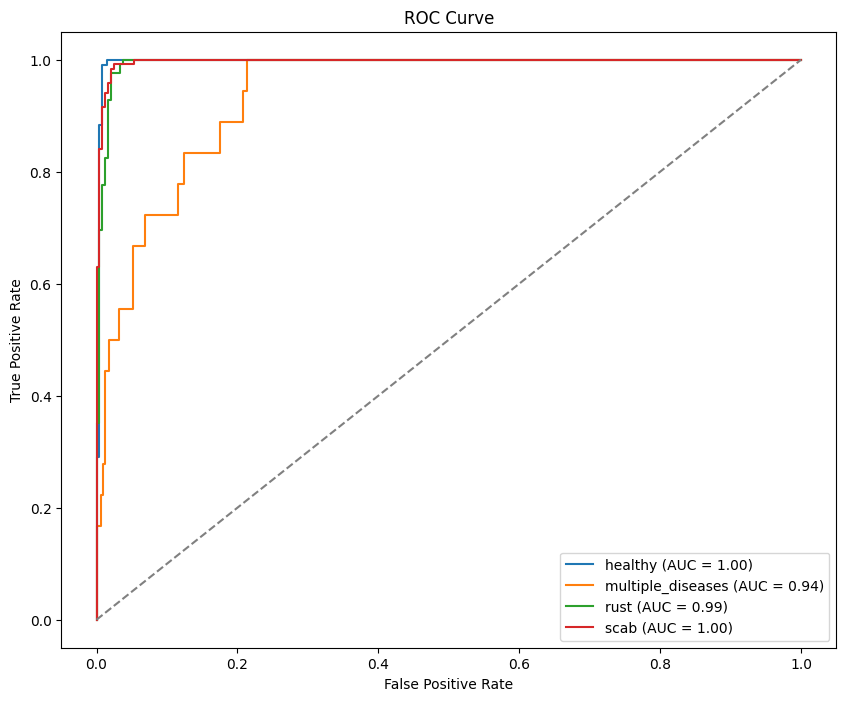


Training fold 2...
Epoch 1/15 - Fold 2
Training Loss: 1.1504, Validation Loss: 1.0067, Validation Accuracy: 0.4519
Epoch 2/15 - Fold 2
Training Loss: 1.0839, Validation Loss: 0.9505, Validation Accuracy: 0.5666
Epoch 3/15 - Fold 2
Training Loss: 1.0078, Validation Loss: 0.8471, Validation Accuracy: 0.6367
Epoch 4/15 - Fold 2
Training Loss: 0.9363, Validation Loss: 0.7380, Validation Accuracy: 0.6779
Epoch 5/15 - Fold 2
Training Loss: 0.8500, Validation Loss: 0.6365, Validation Accuracy: 0.7253
Epoch 6/15 - Fold 2
Training Loss: 0.8223, Validation Loss: 0.5691, Validation Accuracy: 0.7582
Epoch 7/15 - Fold 2
Training Loss: 0.7779, Validation Loss: 0.5182, Validation Accuracy: 0.7816
Epoch 8/15 - Fold 2
Training Loss: 0.7246, Validation Loss: 0.4800, Validation Accuracy: 0.8139
Epoch 9/15 - Fold 2
Training Loss: 0.7454, Validation Loss: 0.4632, Validation Accuracy: 0.8365
Epoch 10/15 - Fold 2
Training Loss: 0.7258, Validation Loss: 0.4433, Validation Accuracy: 0.8420
Epoch 11/15 - Fold 

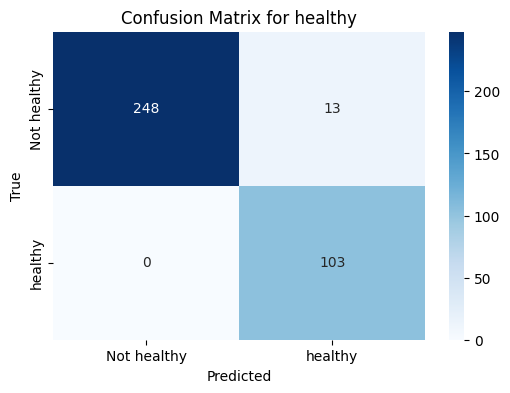


Metrics for class: multiple_diseases
  True Positives (TP): 12
  False Positives (FP): 48
  False Negatives (FN): 6
  True Negatives (TN): 298
  Precision: 0.2000
  Recall: 0.6667
  F1-score: 0.3077


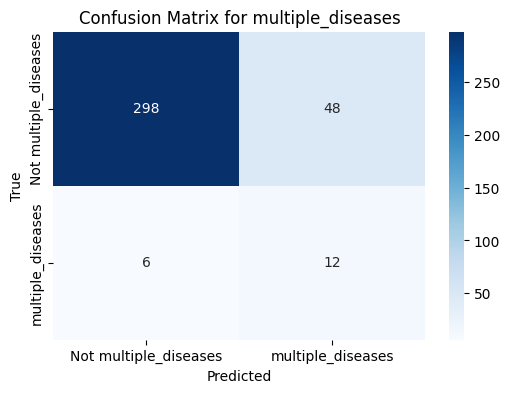


Metrics for class: rust
  True Positives (TP): 124
  False Positives (FP): 6
  False Negatives (FN): 0
  True Negatives (TN): 234
  Precision: 0.9538
  Recall: 1.0000
  F1-score: 0.9764


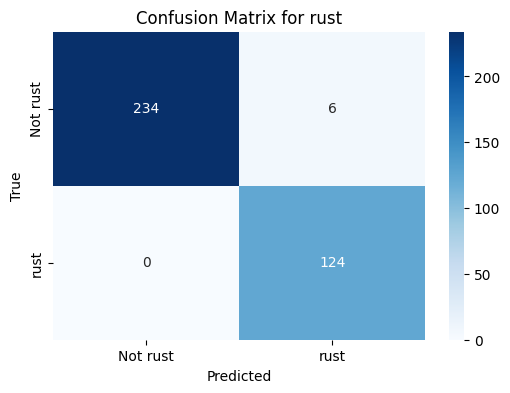


Metrics for class: scab
  True Positives (TP): 116
  False Positives (FP): 9
  False Negatives (FN): 3
  True Negatives (TN): 236
  Precision: 0.9280
  Recall: 0.9748
  F1-score: 0.9508


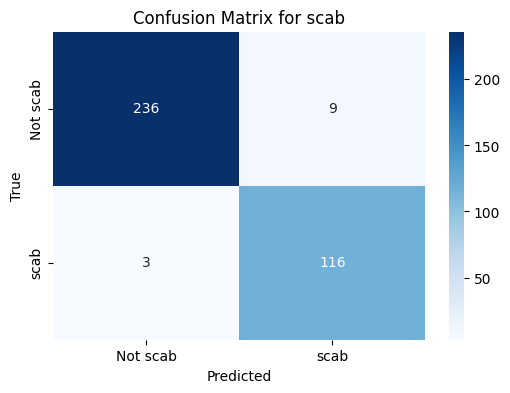

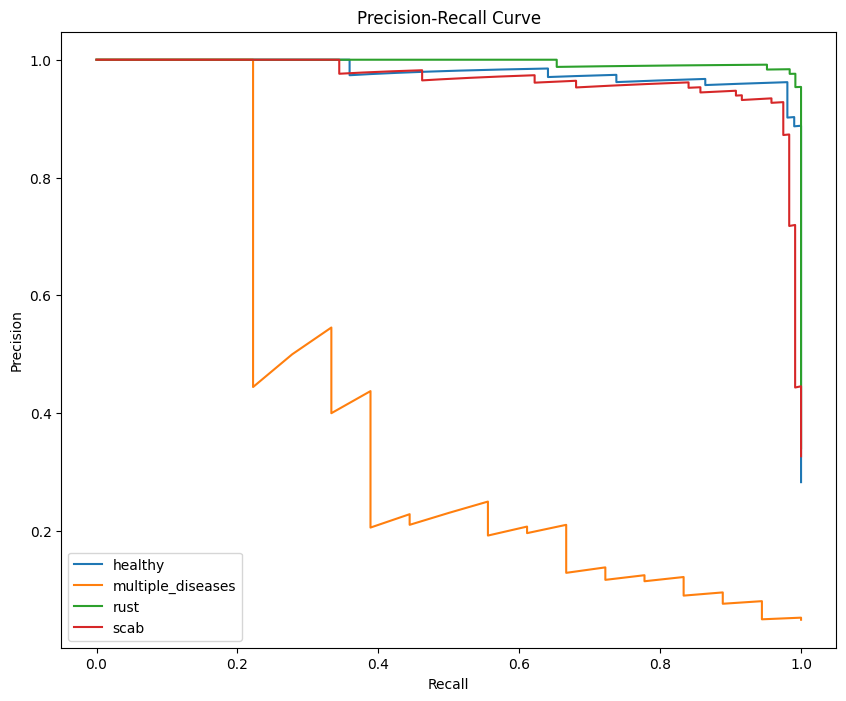

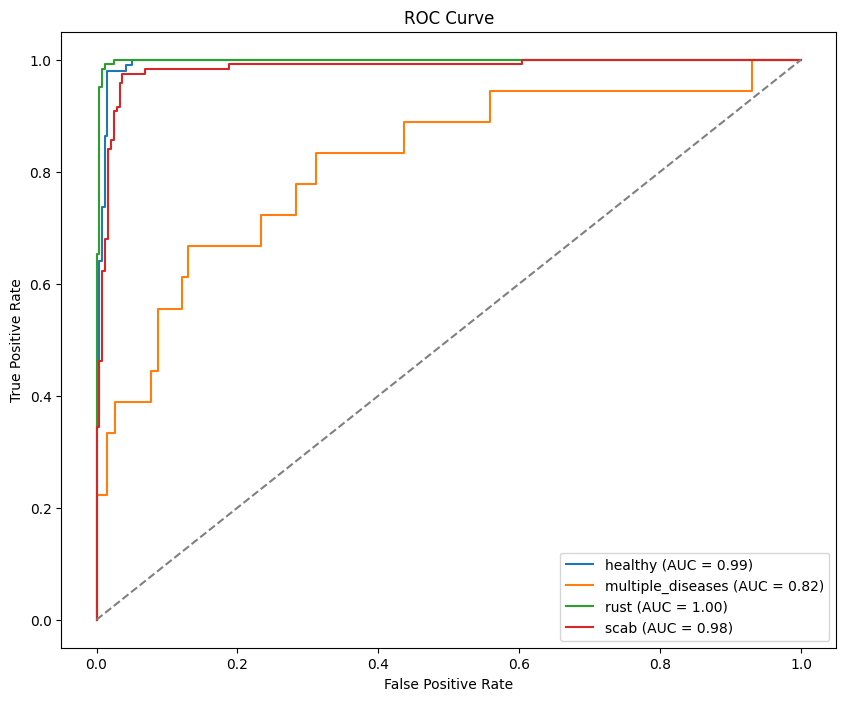


Training fold 3...
Epoch 1/15 - Fold 3
Training Loss: 1.1574, Validation Loss: 1.0056, Validation Accuracy: 0.4911
Epoch 2/15 - Fold 3
Training Loss: 1.0850, Validation Loss: 0.9528, Validation Accuracy: 0.5831
Epoch 3/15 - Fold 3
Training Loss: 1.0167, Validation Loss: 0.8559, Validation Accuracy: 0.6573
Epoch 4/15 - Fold 3
Training Loss: 0.9348, Validation Loss: 0.7318, Validation Accuracy: 0.7054
Epoch 5/15 - Fold 3
Training Loss: 0.8369, Validation Loss: 0.6248, Validation Accuracy: 0.7411
Epoch 6/15 - Fold 3
Training Loss: 0.7976, Validation Loss: 0.5569, Validation Accuracy: 0.7603
Epoch 7/15 - Fold 3
Training Loss: 0.7700, Validation Loss: 0.5171, Validation Accuracy: 0.7898
Epoch 8/15 - Fold 3
Training Loss: 0.7382, Validation Loss: 0.4759, Validation Accuracy: 0.8201
Epoch 9/15 - Fold 3
Training Loss: 0.6921, Validation Loss: 0.4445, Validation Accuracy: 0.8592
Epoch 10/15 - Fold 3
Training Loss: 0.7021, Validation Loss: 0.4329, Validation Accuracy: 0.8777
Epoch 11/15 - Fold 

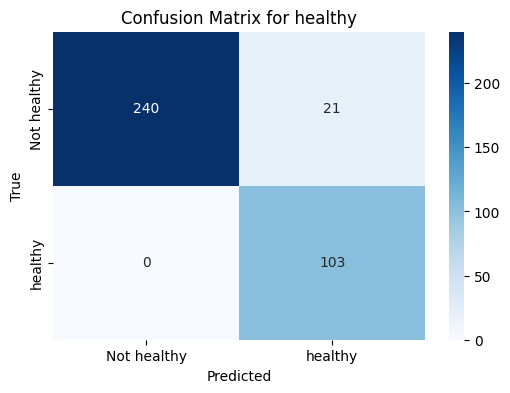


Metrics for class: multiple_diseases
  True Positives (TP): 15
  False Positives (FP): 71
  False Negatives (FN): 4
  True Negatives (TN): 274
  Precision: 0.1744
  Recall: 0.7895
  F1-score: 0.2857


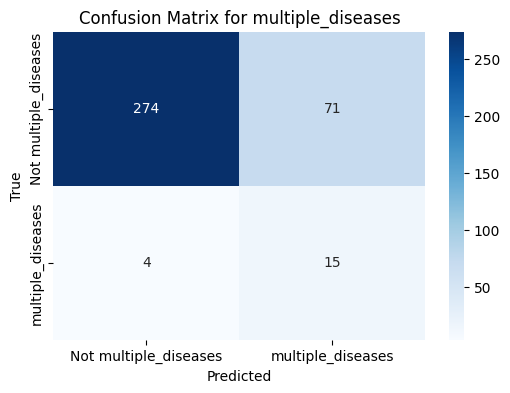


Metrics for class: rust
  True Positives (TP): 123
  False Positives (FP): 7
  False Negatives (FN): 1
  True Negatives (TN): 233
  Precision: 0.9462
  Recall: 0.9919
  F1-score: 0.9685


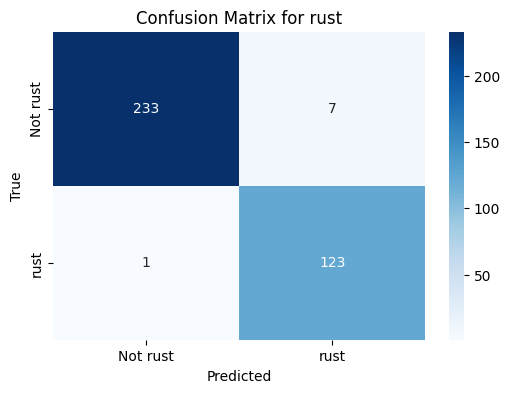


Metrics for class: scab
  True Positives (TP): 111
  False Positives (FP): 7
  False Negatives (FN): 7
  True Negatives (TN): 239
  Precision: 0.9407
  Recall: 0.9407
  F1-score: 0.9407


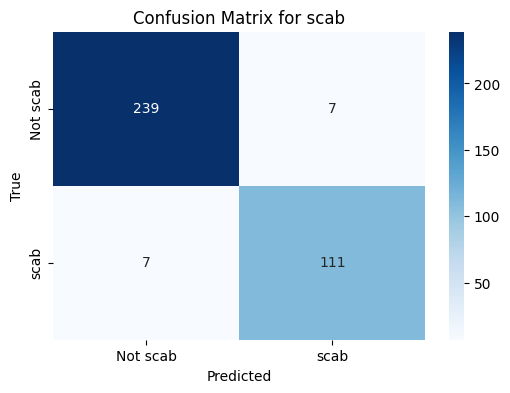

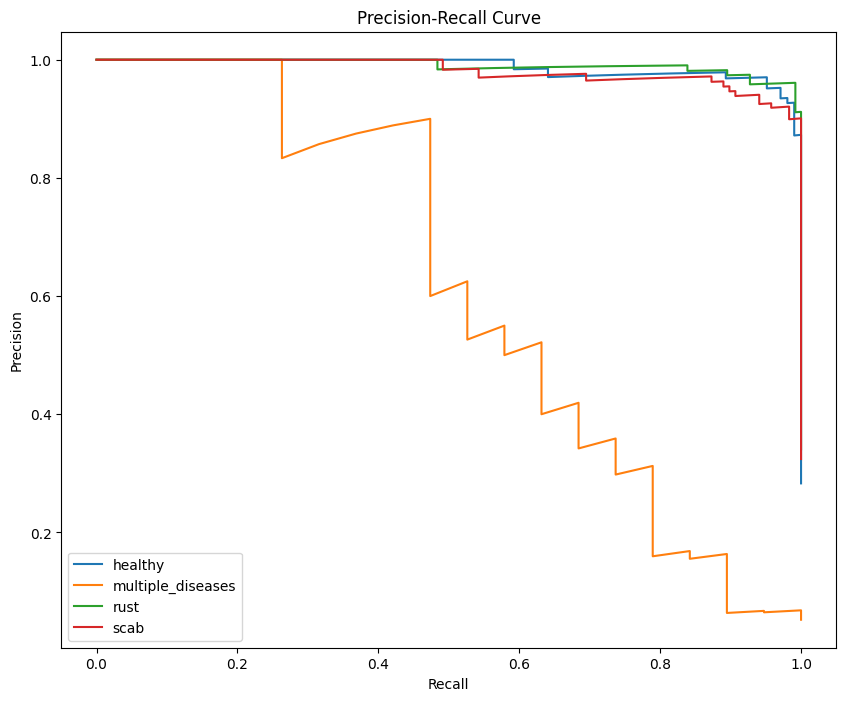

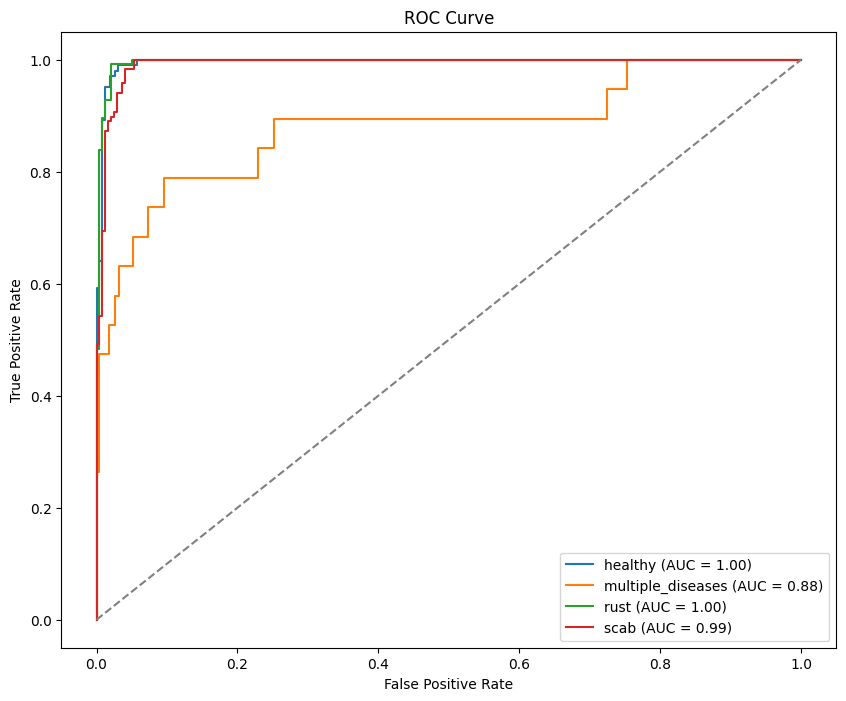


Training fold 4...
Epoch 1/15 - Fold 4
Training Loss: 1.1565, Validation Loss: 0.9919, Validation Accuracy: 0.5124
Epoch 2/15 - Fold 4
Training Loss: 1.0696, Validation Loss: 0.9255, Validation Accuracy: 0.5549
Epoch 3/15 - Fold 4
Training Loss: 0.9976, Validation Loss: 0.8128, Validation Accuracy: 0.6353
Epoch 4/15 - Fold 4
Training Loss: 0.9289, Validation Loss: 0.7120, Validation Accuracy: 0.6806
Epoch 5/15 - Fold 4
Training Loss: 0.8475, Validation Loss: 0.6129, Validation Accuracy: 0.7294
Epoch 6/15 - Fold 4
Training Loss: 0.7798, Validation Loss: 0.5467, Validation Accuracy: 0.7651
Epoch 7/15 - Fold 4
Training Loss: 0.7679, Validation Loss: 0.4998, Validation Accuracy: 0.7864
Epoch 8/15 - Fold 4
Training Loss: 0.7440, Validation Loss: 0.4553, Validation Accuracy: 0.8187
Epoch 9/15 - Fold 4
Training Loss: 0.7198, Validation Loss: 0.4366, Validation Accuracy: 0.8310
Epoch 10/15 - Fold 4
Training Loss: 0.6707, Validation Loss: 0.4075, Validation Accuracy: 0.8654
Epoch 11/15 - Fold 

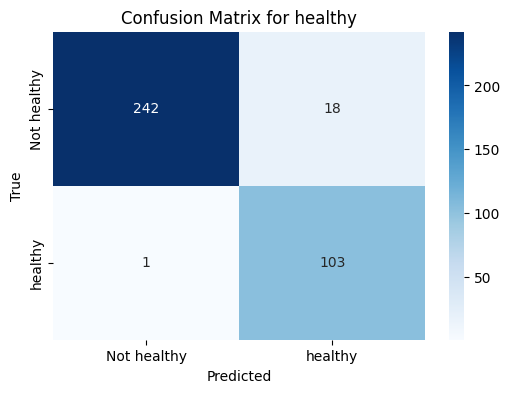


Metrics for class: multiple_diseases
  True Positives (TP): 15
  False Positives (FP): 47
  False Negatives (FN): 3
  True Negatives (TN): 299
  Precision: 0.2419
  Recall: 0.8333
  F1-score: 0.3750


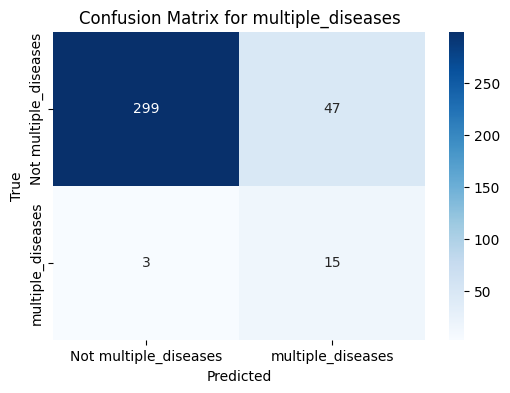


Metrics for class: rust
  True Positives (TP): 124
  False Positives (FP): 10
  False Negatives (FN): 0
  True Negatives (TN): 230
  Precision: 0.9254
  Recall: 1.0000
  F1-score: 0.9612


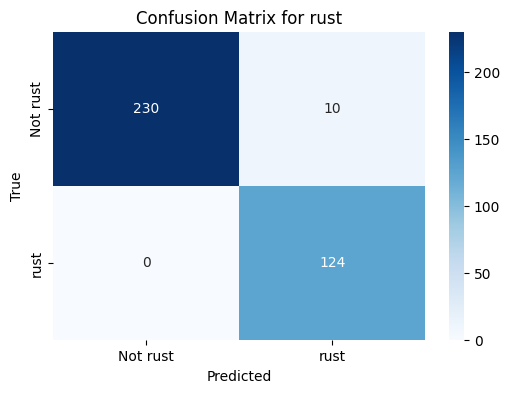


Metrics for class: scab
  True Positives (TP): 115
  False Positives (FP): 5
  False Negatives (FN): 3
  True Negatives (TN): 241
  Precision: 0.9583
  Recall: 0.9746
  F1-score: 0.9664


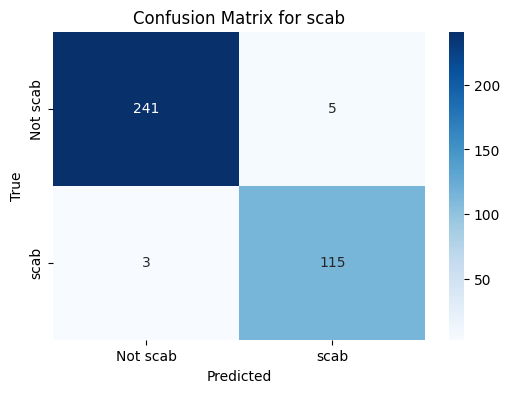

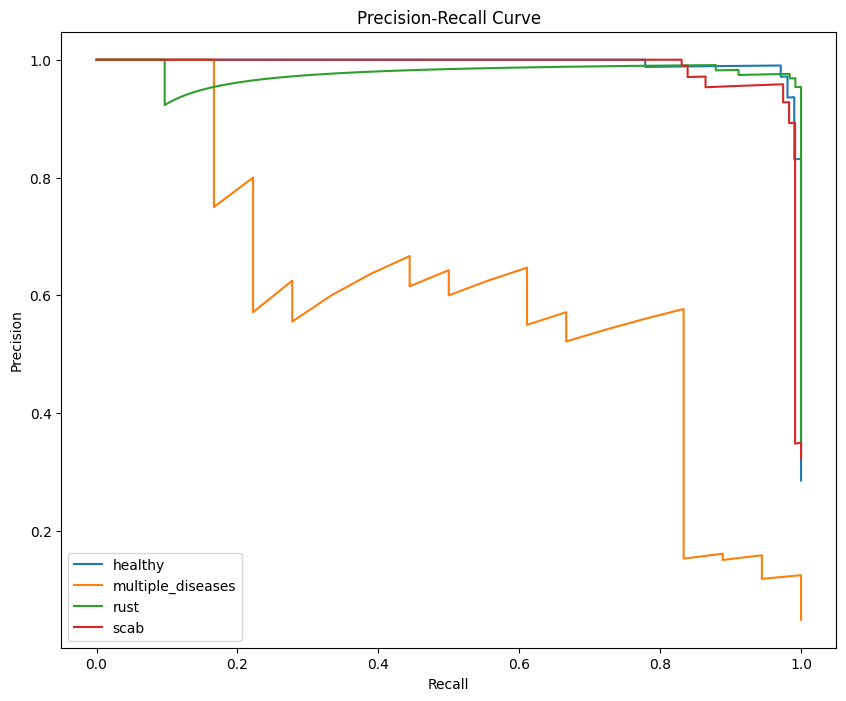

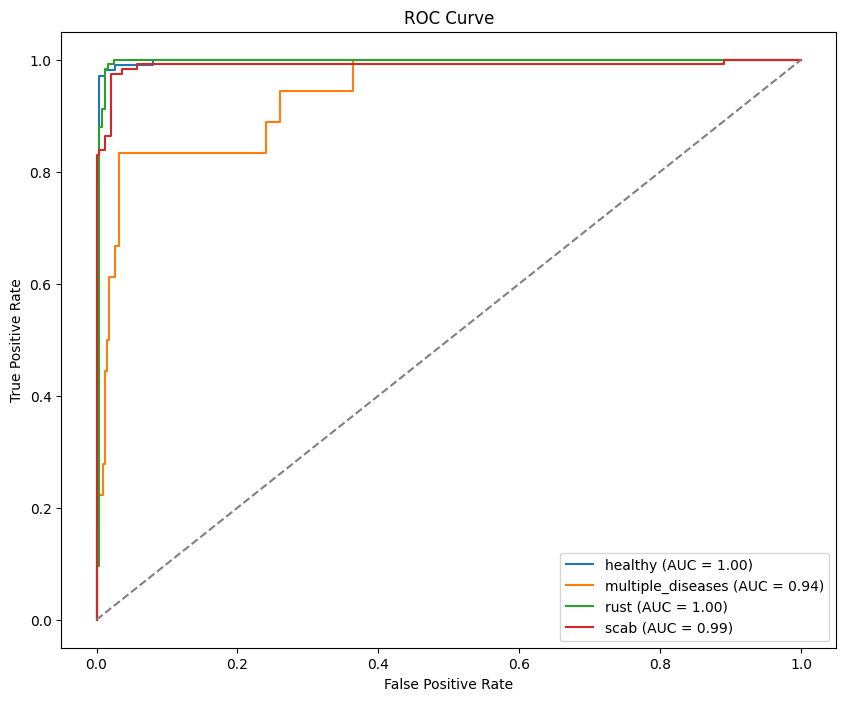


Training fold 5...
Epoch 1/15 - Fold 5
Training Loss: 1.1549, Validation Loss: 1.0053, Validation Accuracy: 0.4794
Epoch 2/15 - Fold 5
Training Loss: 1.0802, Validation Loss: 0.9568, Validation Accuracy: 0.5584
Epoch 3/15 - Fold 5
Training Loss: 1.0190, Validation Loss: 0.8608, Validation Accuracy: 0.6380
Epoch 4/15 - Fold 5
Training Loss: 0.9330, Validation Loss: 0.7482, Validation Accuracy: 0.6696
Epoch 5/15 - Fold 5
Training Loss: 0.8401, Validation Loss: 0.6420, Validation Accuracy: 0.7081
Epoch 6/15 - Fold 5
Training Loss: 0.8315, Validation Loss: 0.5646, Validation Accuracy: 0.7541
Epoch 7/15 - Fold 5
Training Loss: 0.7563, Validation Loss: 0.5178, Validation Accuracy: 0.7713
Epoch 8/15 - Fold 5
Training Loss: 0.7954, Validation Loss: 0.4871, Validation Accuracy: 0.7905
Epoch 9/15 - Fold 5
Training Loss: 0.6904, Validation Loss: 0.4449, Validation Accuracy: 0.8255
Epoch 10/15 - Fold 5
Training Loss: 0.7477, Validation Loss: 0.4322, Validation Accuracy: 0.8640
Epoch 11/15 - Fold 

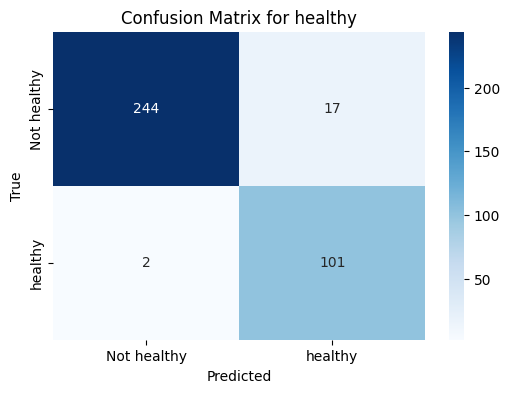


Metrics for class: multiple_diseases
  True Positives (TP): 16
  False Positives (FP): 43
  False Negatives (FN): 2
  True Negatives (TN): 303
  Precision: 0.2712
  Recall: 0.8889
  F1-score: 0.4156


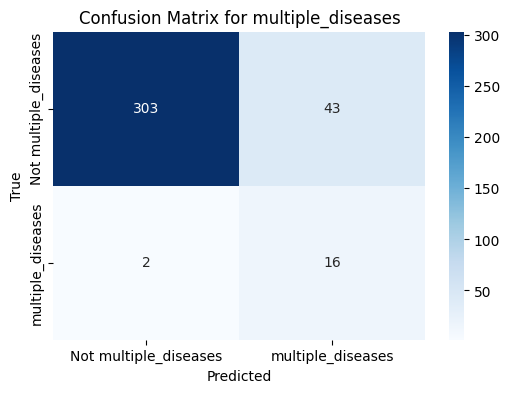


Metrics for class: rust
  True Positives (TP): 125
  False Positives (FP): 15
  False Negatives (FN): 0
  True Negatives (TN): 224
  Precision: 0.8929
  Recall: 1.0000
  F1-score: 0.9434


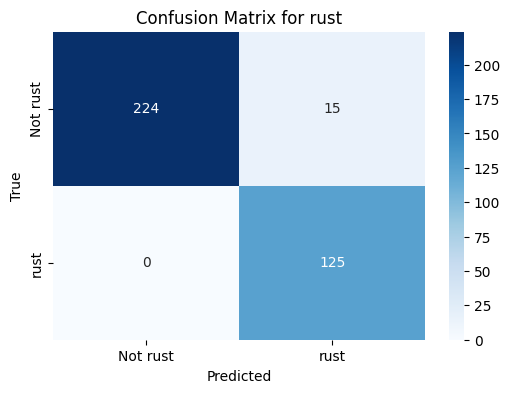


Metrics for class: scab
  True Positives (TP): 111
  False Positives (FP): 2
  False Negatives (FN): 7
  True Negatives (TN): 244
  Precision: 0.9823
  Recall: 0.9407
  F1-score: 0.9610


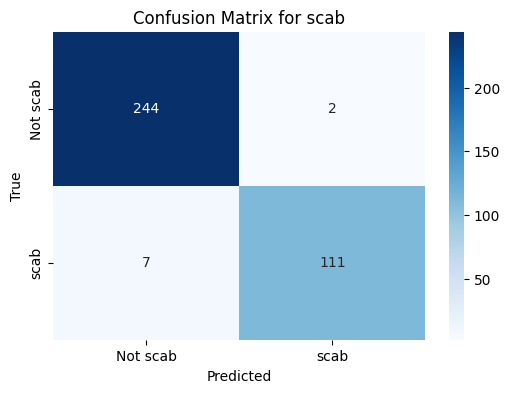

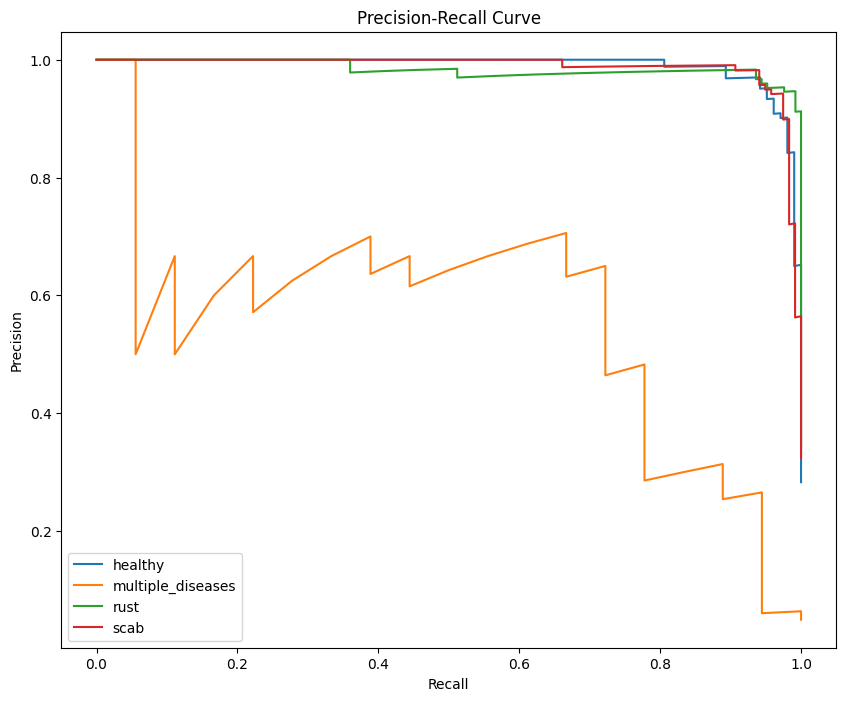

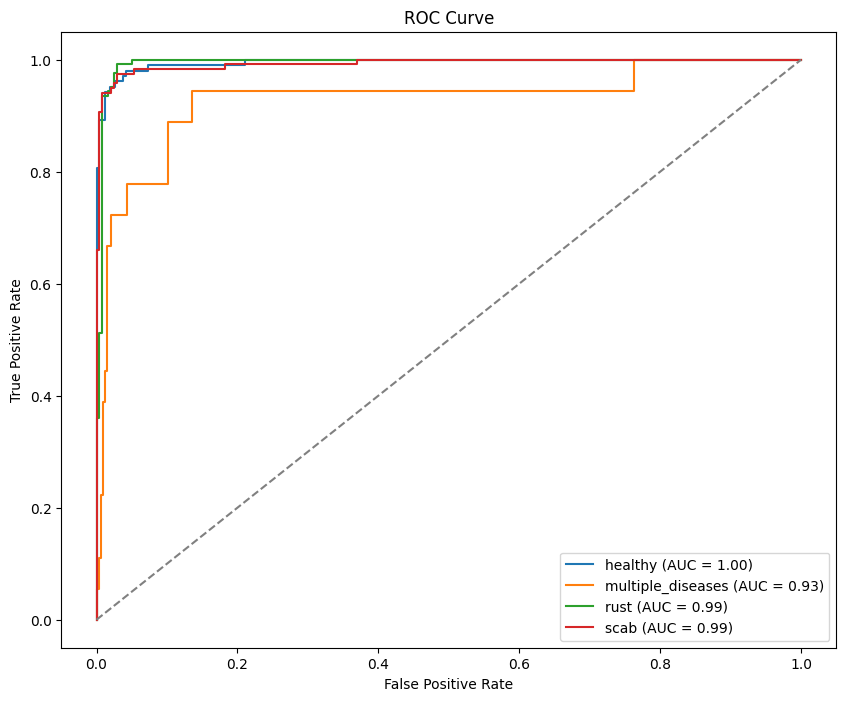

Kaggle submission file 'submission.csv' generated successfully!
  image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.079743           0.736328  0.962669  0.046480
1   Test_1  0.138802           0.663561  0.930570  0.062372
2   Test_2  0.081080           0.384198  0.057471  0.984662
3   Test_3  0.972310           0.406216  0.104316  0.094210
4   Test_4  0.144024           0.476146  0.945694  0.127008


In [ ]:
from sklearn.model_selection import StratifiedKFold
from torchvision import models, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import BCEWithLogitsLoss
from copy import deepcopy
import os # Import os for path manipulation

# Data augmentation for better generalization
# V8->V9 lessened the strength of augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply validation transforms to test dataset
test_data.transform = val_transform

# Create test DataLoader
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Model initialization
# Running resnet18 for comparison
def initialize_model():
    model = models.resnet18(weights=None)
    # Construct the full path to the .pth file inside the downloaded directory
    # The kagglehub.dataset_download for single files returns the direct path to the file.
    # Fix: Join the directory path with the actual filename
    weights_file_path = os.path.join(rnapark_resnet18_f37072fd_pth_path, 'resnet18-f37072fd.pth')
    state_dict = torch.load(weights_file_path, map_location="cpu")
    model.load_state_dict(state_dict)
    # Added dropout layer
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(model.fc.in_features, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(512, 4)  # Output layer
    )
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare labels and class weights
y_single = [np.argmax(sample[1]) for sample in train_data]  # For stratification
all_labels = torch.stack([torch.tensor(sample[1], dtype=torch.float32) for sample in train_data])
pos = all_labels.sum(dim=0)
neg = all_labels.shape[0] - pos
pos_weight = (neg / (pos + 1e-5)).to(device)

# K-Fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Variables to track training and predictions
all_train_losses = []
all_val_accuracies = []
fold_accuracies = []
fold_test_predictions = []  # <- Store test predictions per fold

# K-Fold training loop
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, y_single)):
    print(f"\nTraining fold {fold + 1}...")

    # Deepcopy datasets to avoid transform overwrite
    train_dataset = deepcopy(train_data)
    val_dataset   = deepcopy(train_data)
    train_dataset.transform = train_transform
    val_dataset.transform   = val_transform

    # Build DataLoaders for this fold
    train_loader_fold = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, train_idx),
                                                    batch_size=64, shuffle=True)
    val_loader_fold = torch.utils.data.DataLoader(torch.utils.data.Subset(val_dataset, val_idx),
                                                  batch_size=64, shuffle=False)

    # Initialize model, optimizer, scheduler
    model = initialize_model().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-6)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=2e-4,
        epochs=15,
        steps_per_epoch=len(train_loader_fold),
        pct_start=0.2,
        div_factor=10,
        final_div_factor=100
    )
    loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight, reduction="mean")
    patience = 5

    best_val_loss = float('inf')
    best_val_accuracy = 0
    epochs_without_improvement = 0

    train_losses = []
    val_losses = []
    val_accuracies = []

    # 15 epochs training
    for epoch in range(15):
        print(f"Epoch {epoch+1}/15 - Fold {fold+1}")
        train_loss = train_loop(train_loader_fold, model, loss_fn, optimizer, device, smoothing=0.02)
        val_loss, val_accuracy = evaluate_model(val_loader_fold, model, loss_fn, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step()

    fold_accuracies.append(best_val_accuracy)
    all_train_losses.extend(train_losses)
    all_val_accuracies.extend(val_accuracies)

    # Separate thresholds for each class (adjust thresholds as needed)
    # Updated thresholds, prioritize improving F1 score
    #thresholds = [0.6, 0.7, 0.4, 0.5]
    # thresholds = [0.6, 0.65, 0.4, 0.45]
    # thresholds = [0.5, 0.55, 0.45, 0.45]
    thresholds = [0.5, 0.6, 0.4, 0.45] # 1, 3, 4 are fixed now, 0.6 better than 0.55, 0.65

    # Get predictions and probabilities from the validation set
    y_true, y_probs = predict_loop(val_loader_fold, model, device)

    # Apply the thresholds: convert probabilities to binary predictions per class
    y_pred = (y_probs >= torch.tensor(thresholds).to(y_probs.device))  # Compare each class prob with its threshold
    y_pred = y_pred.int().numpy()  # Convert boolean to int (0 or 1)

    # Plot confusion matrix and other metrics
    plot_confusion_matrix(y_true.numpy(), y_pred, ['healthy','multiple_diseases','rust','scab'])
    plot_precision_recall_curve(y_true.numpy(), y_probs.numpy(), ['healthy','multiple_diseases','rust','scab'])
    plot_roc_curve(y_true.numpy(), y_probs.numpy(), ['healthy','multiple_diseases','rust','scab'])

    # Generate predictions on the test set for this fold using predict_test_loop
    fold_pred = predict_test_loop(test_loader, model, device)

    # Store the raw probabilities for later averaging
    fold_test_predictions.append(fold_pred)

# After all folds: average predictions
avg_test_predictions = torch.stack(fold_test_predictions).mean(dim=0).cpu()
predictions_np = avg_test_predictions.numpy()
# Build submission DataFrame
submission_columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
submission_df = pd.DataFrame(predictions_np, columns=submission_columns)
submission_df.insert(0, 'image_id', test_data.data['image_id'].tolist())

submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)
print(f"Kaggle submission file '{submission_file_path}' generated successfully!")
print(submission_df.head())

In [ ]:
# Plot training curves and report accuracy
plot_training_curves(all_train_losses, all_val_accuracies)
mean_val_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"\nAverage Validation Accuracy across all folds: {mean_val_accuracy:.4f}")

## Summary/Interpretation of metrics:

### ResNet18 Class Metrics

| Class              | Precision | Recall  | F1-Score |
|--------------------|-----------|---------|----------|
| Healthy            | 0.9186    | 0.9921  | 0.9547   |
| Multiple Diseases  | 0.3714    | 0.5606  | 0.4461   |
| Rust               | 0.9067    | 0.9749  | 0.9392   |
| Scab               | 0.9184    | 0.9565  | 0.9371   |


### ResNet34 Class Metrics

| Class              | Precision | Recall  | F1-Score |
|--------------------|-----------|---------|----------|
| Healthy            | 0.9273    | 0.9903  | 0.9577   |
| Multiple Diseases  | 0.2553    | 0.6667  | 0.3692   |
| Rust               | 0.9318    | 0.9840  | 0.9572   |
| Scab               | 0.9504    | 0.9664  | 0.9583   |


### Average metrics for both models
| Metric             | ResNet18 | ResNet34 |
|--------------------|----------|----------|
| Average Precision  | 0.7788   | 0.7662   |
| Average Recall     | 0.8710   | 0.9019   |
| Average F1-Score   | 0.8193   | 0.8106   |

### Performance Comparison
| Metric             | ResNet18 | ResNet34 |
|--------------------|----------|----------|
| Average Precision  | 0.7788   | 0.7662   |
| Average Recall     | 0.8710   | 0.9019   |
| Average F1-Score   | 0.8193   | 0.8106   |

### Interpretation of results
1. Precision:

ResNet18 has slightly better precision (0.7788) than ResNet34 (0.7662), which suggests that the ResNet18 model is better at identifying true positive cases while avoiding false positives.

2. Recall:

ResNet34 has a higher recall (0.9019) compared to ResNet18 (0.8710), which means that ResNet34 is better at identifying positive instances (sensitivity). Higher recall in the ResNet34 model indicates that it's more likely to catch positive cases, even at the expense of more false positives.

3. F1-Score:
The F1-score is a balanced measure of precision and recall. The difference here is small: ResNet18(0.8193) vs. ResNet34 (0.8106). ResNet18 has a slightly better F1-score, suggesting it strikes a slightly better balance between precision and recall.
